# Document Classification

## Mastering Machine Learning on AWS
### Section 2, Chapter 2

In this notebook we will use data from Kaggle for classification.  These are pre-labelled text documents, found [here](https://www.kaggle.com/datasets/dipankarsrirag/topic-modelling-on-emails).  There are four categories, `Crime` (1100), `Entertainment` (1053), `Politics` (3001), `Science` (4000).  We will work with the `Politics` and `Science` data to train binary classifiers.  The models will use 2300 documents to train, 200 to validate, and 200 to test.  Our initial evaluation metric will be model accuracy.  We will use the model accuracy to choose the best model from the different techniques considered.  Initially, we will train two models, Naive Bayes and Logistic Regression.  We will do some final analysis considering a few other questions regarding errors and missclassifications, and consider questions related to tuning the models in various situations to handle the different classes.

During Data Preprocessing each step each step will be explored and the steps taken will be detailed.  At the model building stage, the steps will be joined together inside a single pipeline for transforming the data from its raw state to its predictive model ingestable state.  Models will then be trained on the completely transformed data before exploring an analysis of the results.

# Contents 

1. [Contents](#Contents)  
2. [Modules and Libraries](#Modules-and-Libraries)  
3. [Download Data](#Download-Data)  
4. [Define data variables and Import Data](#Define-data-variables-and-Import-Data)  
    1. [Importing Data with `read_text_files`](#Importing-Data-with-read_text_files)
5. [Data Exploration](#Data-Exploration)
    1. [Crime Data](#Crime-Data)
    2. [Entertainment Data](#Entertainment-Data)
    3. [Science Data](#Science-Data)
    4. [Politics-Data](#Politics-Data)
6. [Duplicate Data Check](#Duplicate-Data-Check)
    1. [Crime vs Entertainment](#Crime-vs-Entertainment)
    2. [Science vs Politics](#Science-vs-Politics)
    3. [Science vs Crime](#Science-vs-Crime)  
    4. [Politics vs Crime](#Politics-vs-Crime)
    5. [Data Conclusions](#Data-Conclusions)
7. [Data Cleaning and Preperation](#Data-Cleaning-and-Preperation)
    1. [Creating Transformed Data for Processing](#Creating-Transformed-Data-for-Processing)
    2. [Remove Duplicate Data](#Remove-Duplicate-Data)
    3. [Create Lists and Numpy Arrays of the Data](#Create-Lists-and-Numpy-Arrays-of-the-Data)
    4. [Feature Vectorization](#Feature-Vectorization)
        1. [Create DataFrames](#Create-DataFrames)
            1. [Politics, label 1](#Politics,-label-1)
            2. [Science, label 0](#Science,-label-0)
            3. [Combined DataFrame](#Combined-DataFrame)  
    6. [Vectorize the Data](#Vectorize-the-Data)  
8. [Predictive Models](#Predictive-Models)
    1. [Naive Bayes](#Naive-Bayes)  
    2. [Logistic Regression](#Logistic-Regression)  
    3. [K-Nearest Neighbors](#K-Nearest-Neighbors)  

# Modules and Libraries     

In [358]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
import time

import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords') 
# nltk.download('punkt_tab')
# nltk.download("wordnet")
# nltk.download("omw-1.4")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

import bnaivebayes as bnb
import readtextfunctions as rtf
import datacleaning as dc
# import nb

# Download Data

This is the script that was used to download and show where the data is located.
```python
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dipankarsrirag/topic-modelling-on-emails")

print("Path to dataset files:", path)
```
Output: `Path to dataset files: /Users/blakewallace/.cache/kagglehub/datasets/dipankarsrirag/topic-modelling-on-emails/versions/1`

All of the files were moved to the local directory housing the current workbook.  The path to the folder is now `/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents`.  

Note that the data is not actually in the GitHub repository.  It is available for download on the Kaggle platform on the page [Text Classification on Emails](https://www.kaggle.com/datasets/dipankarsrirag/topic-modelling-on-emails).  

# Define data variables and Import Data

## Importing Data with `read_text_files`

This data is in the location on the system that it was downloaded to in the [Download Data](#Download-Data) section.

In [2]:
# utilize the `read_text_files` function in the readtextfunctions file
for directory in ['Crime', 'Entertainment', 'Politics', 'Science']:
    folder_path = "/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/" + directory + "/"
    print(folder_path)
    globals()['text_files_data_{}'.format(directory)] = rtf.read_text_files(folder_path)
    print()


/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Crime/
Error reading 15672.txt: 'utf-8' codec can't decode byte 0xa0 in position 896: invalid start byte

/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Entertainment/
Error reading 15672.txt: 'utf-8' codec can't decode byte 0xa0 in position 896: invalid start byte

/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Politics/

/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Science/
Error reading 15672.txt: 'utf-8' codec can't decode byte 0xa0 in position 896: invalid start byte
Error reading 53721.txt: 'utf-8' codec can't decode byte 0xfd in position 195: invalid start byte
Error reading 53803.txt: 'utf-8' codec can't decode byte 0xfd in position 285: invalid start byte
Error reading 53883.txt: 'utf-8' codec can't decode byte 0xfd in position 390: invalid start byte
Error reading 54070.txt: 'utf-8' codec c

# Data Exploration

## Crime Data

**There are 1099 files in the Crime file.**

In [3]:
len(text_files_data_Crime)

1099

**We need the data to be in lists for some of the functions that will process the data.**

Create a list and a numpy array housing the Crime data.

In [4]:
Crime_list = list()
for key in text_files_data_Crime:
    Crime_list.append(text_files_data_Crime[key])

Crime_array = np.array(Crime_list)
# Crime_array

In [5]:
len(Crime_array)

1099

In [6]:
# need to work to save this as a csv file
pd.DataFrame({'keys':text_files_data_Crime.keys(), 
              'documents':text_files_data_Crime.values()}, 
              index=np.arange(len(text_files_data_Crime))).to_csv(
                                    './data/kaggle/Text_Classification_on_Documents/crime.csv', 
                                    index=False)


In [7]:
Crime_df = pd.read_csv('./data/kaggle/Text_Classification_on_Documents/crime.csv')
print(len(Crime_df))
Crime_df.head()

1099


,keys,documents
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7..."
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...
4,14983.txt,\n Some sick part of me really liked that ph...


## Entertainment Data

**There are 1052 files in the Entertainment file.**

In [8]:
len(text_files_data_Entertainment)

1052

Create a list and a numpy array housing the Entertainment data.

In [9]:
Entertainment_list = list()
for key in text_files_data_Entertainment:
    Entertainment_list.append(text_files_data_Entertainment[key])

Entertainment_array = np.array(Entertainment_list)
# Entertainment_array

In [10]:
len(Entertainment_array)

1052

In [11]:
# need to work to save this as a csv file
pd.DataFrame({'keys':text_files_data_Entertainment.keys(), 
              'documents':text_files_data_Entertainment.values()}, 
              index=np.arange(len(text_files_data_Entertainment))).to_csv(
                        './data/kaggle/Text_Classification_on_Documents/entertainment.csv', 
                        index=False)


In [12]:
Entertainment_df = pd.read_csv(
    './data/kaggle/Text_Classification_on_Documents/entertainment.csv')
print(len(Entertainment_df))
Entertainment_df.head()


1052


,keys,documents
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7..."
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...
4,14983.txt,\n Some sick part of me really liked that ph...


## Science Data

In [13]:
len(text_files_data_Science)

3987

In [14]:
Science_list = list()
for key in text_files_data_Science:
    Science_list.append(text_files_data_Science[key])
# text_files_data_Crime[list(text_files_data_Crime.keys())[0]]

Science_array = np.array(Science_list)
# Science_array

In [15]:
len(Science_array)

3987

In [16]:
# need to work to save this as a csv file
pd.DataFrame({'keys':text_files_data_Science.keys(), 
              'documents':text_files_data_Science.values()}, 
              index=np.arange(len(text_files_data_Science))).to_csv(
                        './data/kaggle/Text_Classification_on_Documents/science.csv', 
                        index=False)


In [17]:
Science_df = pd.read_csv(
    './data/kaggle/Text_Classification_on_Documents/science.csv')
print(len(Science_df))
Science_df.head()


3987


,keys,documents
0,14147.txt,"\nArchive-name: ripem/faq\nLast-update: Sun, 7..."
1,14831.txt,Approved: news-answers-request@MIT.EDU\nConten...
2,14832.txt,Approved: news-answers-request@MIT.EDU\nConten...
3,14982.txt,Message-ID: <1ppvai$l79@bilbo.suite.com>\nRepl...
4,14983.txt,\n Some sick part of me really liked that ph...


## Politics Data

In [18]:
len(text_files_data_Politics)

3000

In [19]:
Politics_list = list()
for key in text_files_data_Politics:
    Politics_list.append(text_files_data_Politics[key])

Politics_array = np.array(Politics_list)
# Politics_array

In [20]:
len(Politics_array)

3000

In [21]:
# need to work to save this as a csv file
pd.DataFrame({'keys':text_files_data_Politics.keys(), 
              'documents':text_files_data_Politics.values()}, 
              index=np.arange(len(text_files_data_Politics))).to_csv(
                        './data/kaggle/Text_Classification_on_Documents/politics.csv', 
                        index=False)


In [22]:
Politics_df = pd.read_csv(
    './data/kaggle/Text_Classification_on_Documents/politics.csv')
print(len(Politics_df))
Politics_df.head()


3000


,keys,documents
0,124146.txt,Nntp-Posting-Host: acvax1\nNntp-Posting-User: ...
1,176845.txt,\nIn <C4v13w.Dup@apollo.hp.com> nelson_p@apoll...
2,176846.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...
3,176847.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...
4,176849.txt,NNTP-Posting-Host: oregon.uoregon.edu\nNews-So...


<a id='Duplicate-Data-Check'></a>
# Duplicate Data Check

## Crime vs Entertainment

**Entertainment and Crime data are corrupt.  We will not use them in our final analysis.**

We can see from the following analysis that every document in the `Entertainment` folder is also in the `Crime` folder.  We will not spend time deciding which data is corrupt.  As will be shown shortly, neither data will be used for the final model training phase.  

**First, attempt to train a model using the two sets of data.  This yields an accuracy of zero.**

Note on functions, we are using our own custome created functions.  See the accompanying file for more details.  

The Naive Bayes model here removes stopwords and uses NLTK's built in word lemmatizer (nltk.stem.WordNetLemmatizer()).  However, at this point in the analysis there is no consideration of any Parts of Speech (POS), and no POS partitioning to determine any type of term importance is being considered.  

In [23]:
# train a `Naive Bayes` model on 1000 elements from each dataset
crimeVSentertainment_weights = bnb.trainNaiveBayes(Crime_array[:1000], Entertainment_array[:1000]) 

There are **14883** terms in this model.

In [24]:
len(crimeVSentertainment_weights)

14854

In [25]:
# training accuracy
bnb.PredAccuracy(Crime_array[:1000], Entertainment_array[:1000], crimeVSentertainment_weights)

0.0

**The training accuracy is 0.0**

**Looking at an example element in the `Crime` data reveals that the two datasets might have the same data.**

The Score function is used to determine which class label to assign to each instance.  The left entry in the output list is associated with the label `Crime`, while the right is associated with the label `Entertainment`.  The higher of the two (which is always non-positive) is the label assigned to the instance.  In this example, the model is not able to assign a class label to the instance because the scores are identical.  This is because when generating the model weights during training the number of each feature associated with each label is identical, so the feature probabilities are identical.  

The data is likely identical in both data sets.

**Example**

In [26]:
# similar score for each of the class labels
bnb.Score(Crime_array[4], crimeVSentertainment_weights)

[-268.83868901017416, -268.83868901017416]

**Notice, all of the scores look to be identical in the weights generated by the Naive Bayes model.  This hints towards duplicate data.**

In [27]:
# first 20 elemnts in the weights dictionary
bnb.print_first_n_items(crimeVSentertainment_weights, 20)

archivename: [-9.230394193210719, -9.230394193210719]
ripemfaq: [-10.904370626782391, -10.904370626782391]
lastupdate: [-10.904370626782391, -10.904370626782391]
sun: [-8.289410848746193, -8.289410848746193]
mar: [-10.61668855433061, -10.61668855433061]
post: [-6.054947926269855, -6.054947926269855]
still: [-6.826833182876672, -6.826833182876672]
rather: [-6.890995127093957, -6.890995127093957]
rough: [-9.80575833811428, -9.80575833811428]
list: [-6.879018936047242, -6.879018936047242]
likely: [-7.27559509673816, -7.27559509673816]
question: [-6.543397401306342, -6.543397401306342]
information: [-5.794392889353872, -5.794392889353872]
ripem: [-7.040138285190594, -7.040138285190594]
program: [-6.336556227338068, -6.336556227338068]
public: [-5.87175642596736, -5.87175642596736]
key: [-4.474651148743254, -4.474651148743254]
mail: [-6.5519444618848, -6.5519444618848]
encryption: [-5.152856749305, -5.152856749305]
faq: [-7.368253927220865, -7.368253927220865]


**We can confirm that all of the weights are identical.**

Number of features in the Naive Bayes model

In [28]:
len(crimeVSentertainment_weights)

14854

**Generate a comparison count between the label scores in the set of weights.**

In [29]:
number_different = 0                                       # count the number that are different
number_checked = 0                                         # count the number that are checked
for key, value in crimeVSentertainment_weights.items():
    if value[0] == value[1]:                               # compare each entry
        number_checked += 1
    else:
        number_different += 1
        number_checked += 1

print('Number different:' + color.BOLD + f' {number_different}' + color.END)
print('Number checked:' + color.BOLD + f' {number_checked}' + color.END)
print('Number identical:' + color.BOLD + f' {number_checked - number_different}' + color.END)

Number different: 0
Number checked: 14854
Number identical: 14854


**The intersection of `Crime` and `Entertainment` has 1052 elements, which is the exact number of elements in the `Entertainment` file.  Thus, everything in the `Entertainment` file is in the `Crime` file.  Duplicate data.**

In [30]:
# Intersection, Crime vs Entertainment
len(set(text_files_data_Crime.keys()).intersection(set(text_files_data_Entertainment.keys())))

1052

**47 elements are present in the `Crime` file and not the `Entertainment` file**

In [31]:
# Show the number of elements in the Crime file that are not in the Entertainment file
len(set(text_files_data_Crime.keys()) - set(text_files_data_Entertainment.keys()))

47

**Here are the 47 document keys present in the `Crime` file that are not present in the `Entertainment` file.**

In [32]:
# Crime and Not Entertainment
print(list(set(text_files_data_Crime.keys()) - set(text_files_data_Entertainment.keys())))

['52767.txt', '52778.txt', '52771.txt', '52806.txt', '52779.txt', '52772.txt', '52770.txt', '52811.txt', '52808.txt', '52787.txt', '52783.txt', '52781.txt', '52801.txt', '52777.txt', '52792.txt', '52780.txt', '52775.txt', '52804.txt', '52812.txt', '52769.txt', '52803.txt', '52790.txt', '52813.txt', '52810.txt', '52782.txt', '52799.txt', '52768.txt', '52809.txt', '52773.txt', '52789.txt', '52786.txt', '52788.txt', '52805.txt', '52797.txt', '52798.txt', '52796.txt', '52802.txt', '52807.txt', '52785.txt', '52774.txt', '52794.txt', '52784.txt', '52795.txt', '52791.txt', '52800.txt', '52793.txt', '52776.txt']


**We will look more closely at the other sets of docuements to make sure there are no duplicates in them.**

## Science vs Politics 

**266** elements are in both the Science and Politics sets of documents

In [33]:
# Science, number of elements
len(text_files_data_Science)

3987

In [34]:
# Politics, number of elements
len(text_files_data_Politics)

3000

In [35]:
# Intersection, Science vs Politics
len(set(text_files_data_Science.keys()).intersection(set(text_files_data_Politics.keys())))

266

**266 documents are in both `Politics` and `Science`.**

In [36]:
# create a list of shared keys
shared_keys_PvsS = list()
for key in text_files_data_Science.keys():
    if key in text_files_data_Politics:
        shared_keys_PvsS.append(key)

# number of shared keys
print('Number of shared keys:' + color.BOLD + f' {len(shared_keys_PvsS)}' + color.END + '\n')

# the first five document keys
print(f'The first five shared documents: {shared_keys_PvsS[:5]}.')

Number of shared keys: 266

The first five shared documents: ['54116.txt', '54117.txt', '54118.txt', '54119.txt', '54120.txt'].


## Science vs Crime

In [37]:
# Science, number of elements
len(text_files_data_Science)

3987

In [38]:
# Intersection, Science vs Crime
len(set(text_files_data_Science.keys()).intersection(set(text_files_data_Crime.keys())))

1099

In [39]:
# Crime, number of elements
len(text_files_data_Crime)

1099

**Every element in the `Crime` dataset is in the `Science` dataset.**

## Politics vs Crime

In [40]:
# Intersection, Politics vs Crime
len(set(text_files_data_Politics.keys()).intersection(set(text_files_data_Crime.keys())))

0

**There is no overlap between the `Politics` and `Crime` datasets.  A classifier could be trained between them.**

## Data Conclusions

It has been found that everything in `Entertainment` is in `Crime`, and everything in `Crime` is in `Science`.  Thus, any attempt to train a classifier between `Science` and `Crime` or `Entertainment` will not work.  This is assuming that there is a uniform transformation done to each set of data.  

There is no overlap between the `Politics` and `Crime` datasets, and there is slight overlap between the `Politics` and `Science` sets.  We could look at two different situations, one classifying between `Politics` and `Crime`, the other between `Politics` and `Science`.  But, the `Crime` set is a subset of the `Science` set.  So, creating a model between `Politics` and `Crime` is the same as creating a model between `Politics` and a subset of `Science`.  We will not do this.  Instead, we will focus exclusively on building models between `Politics` and `Science`.

# Data Cleaning and Preperation

## Creating Transformed Data for Processing

There are several functions being used to perform the data cleaning transformations.  They can be found in two `.py` files that accompany this notebook (`readtextfunctions.py`, `datacleaning.py`).  

All six functions in the `datacleaning.py` file are being used to transform the data.  
The function `read_transform_text_files` is being used from the second.  

In [41]:
start_time = time.time()

# utilize the `read_transform_text_files` function in the readtextfunctions file
for directory in ['Politics', 'Science']:
    folder_path = "/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/" + directory + "/"
    print(folder_path)
    globals()['transformed_text_data_{}'.format(directory)] = rtf.read_transform_text_files(folder_path)
    print()

end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')

/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Politics/

/Users/blakewallace/Repositories/AWS/data/kaggle/Text_Classification_on_Documents/Science/
Error reading 15672.txt: 'utf-8' codec can't decode byte 0xa0 in position 896: invalid start byte
Error reading 53721.txt: 'utf-8' codec can't decode byte 0xfd in position 195: invalid start byte
Error reading 53803.txt: 'utf-8' codec can't decode byte 0xfd in position 285: invalid start byte
Error reading 53883.txt: 'utf-8' codec can't decode byte 0xfd in position 390: invalid start byte
Error reading 54070.txt: 'utf-8' codec can't decode byte 0xfe in position 176: invalid start byte
Error reading 54071.txt: 'utf-8' codec can't decode byte 0xfe in position 209: invalid start byte
Error reading 54485.txt: 'utf-8' codec can't decode byte 0xf6 in position 1532: invalid start byte
Error reading 59055.txt: 'utf-8' codec can't decode byte 0xff in position 728: invalid start byte
Error reading 59239.txt: 'utf-8

In [42]:
len(transformed_text_data_Politics)

3000

In [43]:
len(transformed_text_data_Science)

3987

## Remove Duplicate Data

In [44]:
len(shared_keys_PvsS)

266

In [45]:
# remove the entries in the dictionaries `shared_keys_PvsS` with the shared keys between Politics and Science
for key in shared_keys_PvsS:
    transformed_text_data_Politics.pop(key)
    transformed_text_data_Science.pop(key)

In [46]:
len(transformed_text_data_Politics)

2734

In [47]:
len(transformed_text_data_Science)

3721

## Create Lists and Numpy Arrays of the Data

In [48]:
# Science Data
Science_list_transformed = list()
for key in transformed_text_data_Science:
    Science_list_transformed.append(transformed_text_data_Science[key])

Science_array_transformed = np.array(Science_list_transformed)

In [49]:
# Politics Data
Politics_list_transformed = list()
for key in transformed_text_data_Politics:
    Politics_list_transformed.append(transformed_text_data_Politics[key])

Politics_array_transformed = np.array(Politics_list_transformed)

## Feature Vectorization

Two feature vectors for each data point will be considered, count vectorizer and tf_idf.  The first counts the number of occurences of each feature in the vocabulary that appear in the document.  The second weights each feature count by multiplying by a log transformation of the number of documents that which contain that feature.  The acutal formul for the tr-idf transformation is

$$(\text{number of times term } t \text{ appears in document } d) \times \Big(\text{log}\frac{\text{n}_d}{1 + \text{df}(d,t)} + 1 \Big),$$

where n$_d$ is the total number of documents, and $\text{df}(d,t)$ is the count of the number of documents $d$ that contain the term $t$.  This is the default calculation used within scikit-learn's `TfidfVectorizer` method.

### Create DataFrames

#### Politics, label 1

In [50]:
politics_df = pd.DataFrame(transformed_text_data_Politics.keys(), columns=['key']).join(
              pd.DataFrame(Politics_array_transformed, columns=['document']))

politics_df['label'] = 1
politics_df

,key,document,label
0,124146.txt,cant find source state retract claim go dig on...,1
1,176845.txt,norway appear post place always escape underst...,1
2,176846.txt,main point human yet bear bind contract wrong ...,1
3,176847.txt,case dismiss interest authority ground dismiss...,1
4,176849.txt,tax protesters legally correct put jail anyway...,1
...,...,...,...
2729,77820.txt,armies attack suppose brave slaughter athletes...,1
2730,77821.txt,fair traditional jewish christian think actual...,1
2731,77822.txt,lovely arguments write historical ownership pl...,1
2732,77823.txt,anas much pay write,1


#### Science, label 0

In [51]:
science_df = pd.DataFrame(transformed_text_data_Science.keys(), columns=['key']).join(
             pd.DataFrame(Science_array_transformed, columns=['document']))

science_df['label'] = 0
science_df

,key,document,label
0,14147.txt,post still rather rough list likely question i...,0
1,14831.txt,text usenet version title post list likely que...,0
2,14832.txt,text usenet version title live list potential ...,0
3,14982.txt,access try ftp rsa com login anonymous several...,0
4,14983.txt,sick part really like phrase merely threat lon...,0
...,...,...,...
3716,62615.txt,write staffer tell interest story cost team lo...,0
3717,62616.txt,sez object would interfere anyones enjoyment n...,0
3718,62708.txt,accord person talk propose billboard small res...,0
3719,62709.txt,x sure consider sacrilegious doubtfull credibi...,0


#### Combined DataFrame

In [52]:
data_df = pd.concat([politics_df.iloc[:2700], science_df.iloc[:2700]], axis=0)
data_df.head()

,key,document,label
0,124146.txt,cant find source state retract claim go dig on...,1
1,176845.txt,norway appear post place always escape underst...,1
2,176846.txt,main point human yet bear bind contract wrong ...,1
3,176847.txt,case dismiss interest authority ground dismiss...,1
4,176849.txt,tax protesters legally correct put jail anyway...,1


### Vectorize the Data

In [53]:
X = data_df['document']
y = data_df['label']

In [54]:
X

0       cant find source state retract claim go dig on...
1       norway appear post place always escape underst...
2       main point human yet bear bind contract wrong ...
3       case dismiss interest authority ground dismiss...
4       tax protesters legally correct put jail anyway...
                              ...                        
2695    restate thread go stimulate antidepressant unf...
2696    theres chiropractor stand middle shop mall off...
2697    want know follow scam theres chiropractor stan...
2698    anyone know study long term health effect man ...
2699    take antihistamines nights start paradoxical e...
Name: document, Length: 5400, dtype: object

In [55]:
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=270, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=540, stratify=y_tr, random_state=0)

In [56]:
print('Training X: ' + color.BOLD + f'{ len(X_tr)}' + color.END)
print('Training label: ' + color.BOLD + f'{ len(y_tr)}' + color.END)
print('Validation X: ' + color.BOLD + f'{ len(X_val)}' + color.END)
print('Validation label: ' + color.BOLD + f'{ len(y_val)}' + color.END)
print('Testing X: ' + color.BOLD + f'{ len(X_test)}' + color.END)
print('Testing label: ' + color.BOLD + f'{ len(y_test)}' + color.END)

Training X: 5130
Training label: 5130
Validation X: 540
Validation label: 540
Testing X: 270
Testing label: 270


In [57]:
y_train.value_counts()

1    2295
0    2295
Name: label, dtype: int64

In [58]:
y_val.value_counts()

1    270
0    270
Name: label, dtype: int64

In [59]:
y_test.value_counts()

1    135
0    135
Name: label, dtype: int64

In [60]:
# Instantiate the "CountVectorizer" object, which is scikit-learn's bag of words tool.
count_vectorizer = CountVectorizer(min_df=9/5000, max_df=0.5)           # remove any word not in at most 9 documents and any word in more than half the documents
tfidf_vectorizer = TfidfVectorizer(min_df=9/5000, max_df=0.5)

# count_vectorizer = CountVectorizer()           # remove any word not in at most 9 documents and any word in more than half the documents
# tfidf_vectorizer = TfidfVectorizer()

# fit the vectorizer to the Training set
train_data_features_cvec = count_vectorizer.fit_transform(np.array(X_train))
train_data_features_tfidf = tfidf_vectorizer.fit_transform(np.array(X_train))

# use the trained vectorizer to transform the Validation set
validation_data_features_cvec = count_vectorizer.transform(X_val)
validation_data_features_tfidf = tfidf_vectorizer.transform(X_val)

# train_data_features = train_data_features.toarray()


In [61]:
train_data_features_cvec.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [62]:
print(train_data_features_cvec.shape)
print(train_data_features_tfidf.shape)

(4590, 5501)
(4590, 5501)


In [63]:
print(validation_data_features_cvec.shape)
print(validation_data_features_tfidf.shape)

(540, 5501)
(540, 5501)


In [64]:
X_train[:2]

679     critisism easy solutions people would better l...
2567    xxxviii turn notion ives funnel law want spy t...
Name: document, dtype: object

In [65]:
np.arange(len(train_data_features_cvec.toarray()))

array([   0,    1,    2, ..., 4587, 4588, 4589])

In [66]:
X_train_df_cvec = pd.DataFrame(train_data_features_cvec.toarray(), 
                               index = np.arange(len(train_data_features_cvec.toarray())), 
                               columns = count_vectorizer.get_feature_names())
X_train_df_cvec.head()

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
X_val_df_cvec = pd.DataFrame(validation_data_features_cvec.toarray(), 
                             index = np.arange(len(validation_data_features_cvec.toarray())), 
                             columns = count_vectorizer.get_feature_names())
X_val_df_cvec.head()

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
X_train_df_tfidf = pd.DataFrame(train_data_features_tfidf.toarray(), 
                                index = np.arange(len(train_data_features_tfidf.toarray())), 
                                columns = tfidf_vectorizer.get_feature_names())
X_train_df_tfidf.head()

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.006934,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01132,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
X_val_df_tfidf = pd.DataFrame(validation_data_features_tfidf.toarray(), 
                              index = np.arange(len(validation_data_features_tfidf.toarray())), 
                              columns = tfidf_vectorizer.get_feature_names())
X_val_df_tfidf.head()

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.10084,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
train_df = pd.concat([pd.DataFrame({"clean_training_data":X_train}, index=X_train.index), 
                      pd.DataFrame({"label":y_train}, index=X_train.index),
                      pd.DataFrame({"count_vect":list(train_data_features_cvec.toarray())}, index=X_train.index), 
                      pd.DataFrame({"tf_idf":list(train_data_features_tfidf.toarray())}, index=X_train.index)
                      ], 
                     axis=1)
print('shape:' + color.BOLD + f' {train_df.shape}' + color.END)
train_df.head()

shape: (4590, 4)


,clean_training_data,label,count_vect,tf_idf
679,critisism easy solutions people would better l...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2567,xxxviii turn notion ives funnel law want spy t...,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.006933648073445591..."
1219,someting good mean forever go days leave house...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1323,x r say old keychains see simms silver keyring...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78,hmmm intersting long message care libertaria...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [71]:
train_data_features_cvec.toarray()[0].sum()

20

In [72]:
train_data_features_tfidf.toarray()[0].sum()

4.152509437971699

In [73]:
validation_df = pd.concat([pd.DataFrame({"clean_training_data":X_val}), 
                           pd.DataFrame({"label":y_val}, index=X_val.index),
                           pd.DataFrame({"count_vect":list(validation_data_features_cvec.toarray())}, index=X_val.index), 
                           pd.DataFrame({"tf_idf":list(validation_data_features_tfidf.toarray())}, index=X_val.index)], 
                          axis=1)
print('shape:' + color.BOLD + f' {validation_df.shape}' + color.END)
validation_df.head()

shape: (540, 4)


,clean_training_data,label,count_vect,tf_idf
2195,fmgs citizens alien difficult situation citize...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2450,idea provide financial incentives select form ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1311,accord numerous account compound fire start ar...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1715,battery go dead primarily becaust floor cold t...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10084027543920393,..."
2390,question derive incident gas particles create ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


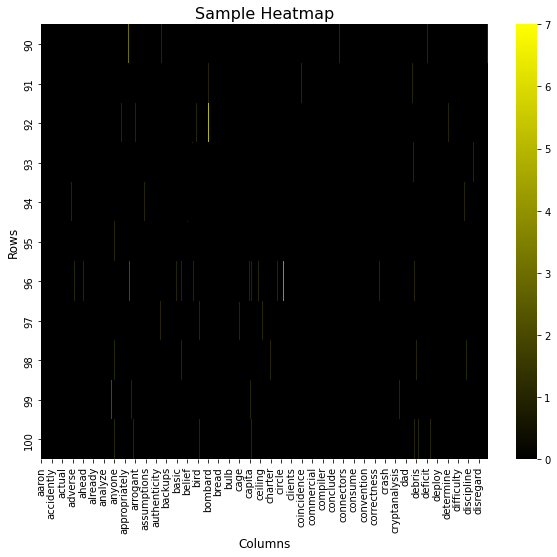

In [356]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

# Generate a sample dataset
np.random.seed(0)
# data = pd.DataFrame(np.random.rand(10, 10), columns=[f'col_{i}' for i in range(10)])
data = X_train_df_cvec.loc[90:100,:'document']
colors = ["black", "yellow"]
cmap = LinearSegmentedColormap.from_list("grey_yellow", colors)

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for better visualization
# sns.heatmap(data, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
sns.heatmap(data, annot=False, cmap=cmap)


# Customize the heatmap
plt.title('Sample Heatmap', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)

# Show the plot
plt.show()

In [349]:
X_train_df_cvec.loc[1, :][X_train_df_cvec.loc[1, :] == 42]

group    42
Name: 1, dtype: int64

In [339]:
np.sort(X_train_df_cvec.loc[1,:][X_train_df_cvec.loc[1, :] != 0])[::-1][:25]

array([42, 35, 32, 31, 28, 23, 23, 21, 20, 20, 17, 16, 15, 15, 14, 14, 13,
       12, 11, 11, 11, 11, 11,  9,  9])

In [326]:
X_train.iloc[1]

'xxxviii turn notion ives funnel law want spy teenager read three saga penetrate become american folk hero build dossiers unsuspecting colleagues time produce film portray informer quintessential american patriot lead three live informant member private citizen mayor even proclaim present spy plaque shy young man come term homosexuality straight arrow life double agent perfect way hide lifestyle fight menace fascinate recently tell federal investigators think would try infiltrate go american delegation give full report return photos take soviet military vehicles hook next two years work unpaid informant find true call become pay spy activities center biggest domestic spy scandal recent american history scandal may end criminal indictment year period compile computer file individuals group political strip include group solidarity group anti apartheid organizations even spy recently slay south african nationalist visit  sell many file anti apartheid activists intelligence pay nearly   us

In [303]:
my_dict = count_vectorizer.vocabulary_

sorted_dict = dict(sorted(my_dict.items()))

print(sorted_dict)

{'aaron': 0, 'abandon': 1, 'abdominal': 2, 'abide': 3, 'ability': 4, 'able': 5, 'abolish': 6, 'abortion': 7, 'abortions': 8, 'abound': 9, 'abridge': 10, 'abroad': 11, 'absence': 12, 'absolute': 13, 'absolutely': 14, 'absorb': 15, 'abstract': 16, 'absurd': 17, 'absurdities': 18, 'abundance': 19, 'abuse': 20, 'abusive': 21, 'ac': 22, 'academia': 23, 'academic': 24, 'academics': 25, 'accelerate': 26, 'accept': 27, 'acceptable': 28, 'acceptance': 29, 'access': 30, 'accessible': 31, 'accident': 32, 'accidental': 33, 'accidentally': 34, 'accidently': 35, 'accidents': 36, 'accommodate': 37, 'accompany': 38, 'accomplish': 39, 'accord': 40, 'accordance': 41, 'accordingly': 42, 'account': 43, 'accountability': 44, 'accountable': 45, 'accumulate': 46, 'accuracy': 47, 'accurate': 48, 'accurately': 49, 'accusation': 50, 'accusations': 51, 'accuse': 52, 'achieve': 53, 'achievement': 54, 'acid': 55, 'acids': 56, 'acknowledge': 57, 'acquaintance': 58, 'acquire': 59, 'acquisition': 60, 'act': 61, 'acti

# Predictive Models

## Create Results DataFrame

In [250]:
# `results`

results_df = pd.DataFrame(index=['train', 'validate', 'test'])
results_df.index.name = 'accuracy'
results_df.columns.name = 'model'
results_df

model
accuracy
train
validate
test


In [226]:
X_train_df_cvec

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
y_train

679     1
2567    1
1219    1
1323    0
78      1
       ..
1822    1
2003    1
2242    1
87      0
2472    0
Name: label, Length: 4590, dtype: int64

In [228]:
# This function was written by Heather Robins.  IN most cases we would attempt to produce our own, but it is 
# beautiful.  So, for this project we chose to use it verbatim, and pass along the credit where it is due.  (Thank you!)
def metrics(y_init, y_predict):
#     print('_________________________________________________________________')
    print('----------------------------------------------------------------')
    print('Accuracy score %s ' % round(accuracy_score(y_init, y_predict), 4), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_init, y_predict), 
                            index=['Actually_Negative', 'Actually_Positive'], 
                            columns=['Predicted_Negative', 'Predicted_Positive']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_init, y_predict))
    print('-----------------------------------------------------------------')

In [229]:
# def metrics_compared(y_train, y_train_preds, y_val, y_val_preds):
#     print('_________________________________________________________________')
#     print('Train Accuracy score %s ' % round(accuracy_score(y_train, y_train_preds), 4), '\n')
#     print('----------------------------------------------------------------')
#     print(pd.DataFrame(confusion_matrix(y_train, y_train_preds), 
#                             index=['Actually_Negative', 'Actually_Positive'], 
#                             columns=['Predicted_Negative', 'Predicted_Positive']), '\n')
#     print('-----------------------------------------------------------------')
#     print(classification_report(y_train, y_train_preds))
#     print('-----------------------------------------------------------------')
#     print('_________________________________________________________________')
#     print('Validation Accuracy score %s ' % round(accuracy_score(y_val, y_val_preds), 4), '\n')
#     print('----------------------------------------------------------------')
#     print(pd.DataFrame(confusion_matrix(y_val, y_val_preds), 
#                             index=['Actually_Negative', 'Actually_Positive'], 
#                             columns=['Predicted_Negative', 'Predicted_Positive']), '\n')
#     print('-----------------------------------------------------------------')
#     print(classification_report(y_val, y_val_preds))
#     print('-----------------------------------------------------------------')

## Naive Bayes

In [230]:
# Import our model!

from sklearn.naive_bayes import MultinomialNB

In [231]:
# Instantiate our model!

start_time = time.time()

# define parameters for a GridSearch
nb_params = {
    'alpha': [1.0, 0.75, 0.5, 0.25, 0.1]
}


# Naive Bayes, Count Vectorizer
nb_cvect = MultinomialNB()
gs_nb_cvec = GridSearchCV(nb_cvect, param_grid=nb_params, verbose=1, cv=3)
gs_nb_cvec.fit(X_train_df_cvec, y_train)
print(gs_nb_cvec.best_score_)
print(gs_nb_cvec.best_params_)


# Naive Bayes, tf-idf Vectorizer
nb_tfidf = MultinomialNB()
gs_nb_tfidf = GridSearchCV(nb_tfidf, param_grid=nb_params, verbose=1, cv=3)
gs_nb_tfidf.fit(X_train_df_cvec, y_train)
print(gs_nb_tfidf.best_score_)
print(gs_nb_tfidf.best_params_)


end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')



Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.9483660130718955
{'alpha': 0.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.9483660130718955
{'alpha': 0.5}
time: 26.442 seconds
time: 0 minutes, 26.442 seconds


In [232]:
nb_train_score_cvec = gs_nb_cvec.score(X_train_df_cvec, y_train)
nb_val_score_cvec = gs_nb_cvec.score(X_val_df_cvec, y_val)
nb_train_score_tfidf = gs_nb_tfidf.score(X_train_df_tfidf, y_train)
nb_val_score_tfidf = gs_nb_tfidf.score(X_val_df_tfidf, y_val)

print('NaiveB Cvect Training Score:' + color.BOLD + f' {round(nb_train_score_cvec, 4)}' + color.END)
print('NaiveB Cvect validation Score:' + color.BOLD + f' {round(nb_val_score_cvec, 4)}' + color.END)
print()
print('NaiveB Tf-idf Training Score:' + color.BOLD + f' {round(nb_train_score_tfidf, 4)}' + color.END)
print('NaiveB Tf-idf validation Score:' + color.BOLD + f' {round(nb_val_score_tfidf, 4)}' + color.END)


NaiveB Cvect Training Score: 0.9564
NaiveB Cvect validation Score: 0.9444

NaiveB Tf-idf Training Score: 0.958
NaiveB Tf-idf validation Score: 0.9481


In [233]:
(gs_nb_cvec.predict(X_train_df_cvec) != gs_nb_tfidf.predict(X_train_df_tfidf)).sum()

31

In [234]:
(gs_nb_cvec.predict(X_val_df_cvec) != gs_nb_tfidf.predict(X_val_df_tfidf)).sum()

8

In [251]:
results_df['nb_cvec'] = np.array([round(nb_train_score_cvec, 4), 
                                  round(nb_val_score_cvec, 4), 
                                  0])
results_df['nb_tfidf'] = np.array([round(nb_train_score_tfidf, 4), 
                                  round(nb_val_score_tfidf, 4), 
                                  0])
results_df

model,nb_cvec,nb_tfidf
accuracy,,
train,0.9564,0.9580
validate,0.9444,0.9481
test,0.0000,0.0000


**The Tf-Idf model has slightly better numbers.  We now consider a error analysis of the model.**

**Confusion Matrix**

In [264]:
y_preds_val_cvec = gs_nb_cvec.predict(X_val_df_cvec)

confusion_matrix(y_val, y_preds_val_cvec)

numpy.ndarray

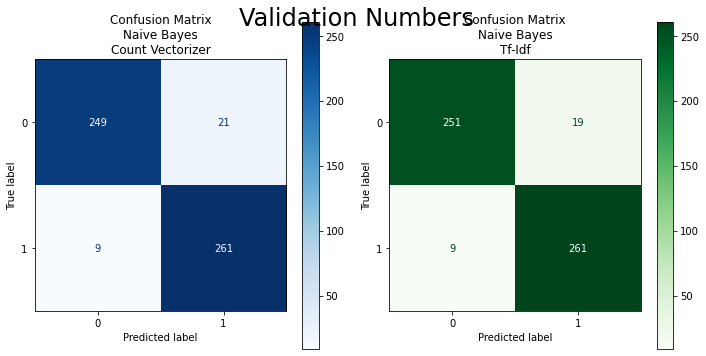

In [279]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example confusion matrices
# cm1 = np.array([[80, 20], [30, 70]])
y_preds_val_cvec = gs_nb_cvec.predict(X_val_df_cvec)
cm1 = confusion_matrix(y_val, y_preds_val_cvec)
# cm2 = np.array([[90, 10], [15, 85]])
y_preds_val_tfidf = gs_nb_tfidf.predict(X_val_df_tfidf)
cm2 = confusion_matrix(y_val, y_preds_val_tfidf)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix\nNaive Bayes\nCount Vectorizer')
axes[0].grid(False)

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(ax=axes[1], cmap=plt.cm.Greens)
axes[1].set_title('Confusion Matrix\nNaive Bayes\nTf-Idf')
axes[1].grid(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Validation Numbers', fontsize=24) #  .title('Validation Numbers')
plt.show()

----------------------------------------------------------------
Accuracy score 0.9444  

----------------------------------------------------------------
                   Predicted_Negative  Predicted_Positive
Actually_Negative                 249                  21
Actually_Positive                   9                 261 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       270
           1       0.93      0.97      0.95       270

    accuracy                           0.94       540
   macro avg       0.95      0.94      0.94       540
weighted avg       0.95      0.94      0.94       540

-----------------------------------------------------------------
----------------------------------------------------------------
Accuracy score 0.9481  

----------------------------------------------------------------
                   Predicted_Negative  Predicted_Positi

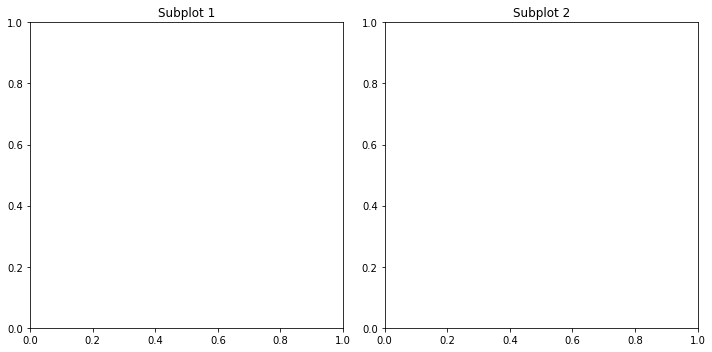

In [261]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# plt.plot([1, 2, 3], [4, 5, 6])
# generating predictions
y_preds_val_cvec = gs_nb_cvec.predict(X_val_df_cvec)

# consider the confusion matrix
metrics(y_val, y_preds_val_cvec)
plt.title('Subplot 1')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# plt.scatter([1, 2, 3], [7, 8, 9])
# validation set, tfidf

# generating predictions
y_preds_val_tfidf = gs_nb_tfidf.predict(X_val_df_tfidf)

# consider the confusion matrix
metrics(y_val, y_preds_val_tfidf)
plt.title('Subplot 2')

plt.tight_layout()
plt.show()

In [254]:
# validation set, cvec

# generating predictions
y_preds_val_cvec = gs_nb_cvec.predict(X_val_df_cvec)

# consider the confusion matrix
metrics(y_val, y_preds_val_cvec)

----------------------------------------------------------------
Accuracy score 0.9444  

----------------------------------------------------------------
                   Predicted_Negative  Predicted_Positive
Actually_Negative                 249                  21
Actually_Positive                   9                 261 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       270
           1       0.93      0.97      0.95       270

    accuracy                           0.94       540
   macro avg       0.95      0.94      0.94       540
weighted avg       0.95      0.94      0.94       540

-----------------------------------------------------------------


In [236]:
# validation set, tfidf

# generating predictions
y_preds_val_tfidf = gs_nb_tfidf.predict(X_val_df_tfidf)

# consider the confusion matrix
metrics(y_val, y_preds_val_tfidf)

----------------------------------------------------------------
Accuracy score 0.9481  

----------------------------------------------------------------
                   Predicted_Negative  Predicted_Positive
Actually_Negative                 251                  19
Actually_Positive                   9                 261 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       270
           1       0.93      0.97      0.95       270

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540

-----------------------------------------------------------------


## Logistic Regression

In [237]:
X_train_df_cvec.head()

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [238]:
start_time = time.time()

# define parameters for a GridSearch
lr_params = {
    'penalty':['l2']
}


# logistic Regression, Count Vectorizer
lr_cvec = LogisticRegression()
gs_lr_cvec = GridSearchCV(lr_cvec, param_grid=lr_params, verbose=1, cv=5)
gs_lr_cvec.fit(X_train_df_cvec, y_train)
print(gs_lr_cvec.best_score_)
print(gs_lr_cvec.best_params_)


# logistic Regression, tf-idf Vectorizer
lr_tfidf = LogisticRegression()
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid=lr_params, verbose=1, cv=5)
gs_lr_tfidf.fit(X_train_df_tfidf, y_train)
print(gs_lr_tfidf.best_score_)
print(gs_lr_tfidf.best_params_)

end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9372549019607843
{'penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.945751633986928
{'penalty': 'l2'}
time: 22.016 seconds
time: 0 minutes, 22.016 seconds


In [239]:
lr_train_score_cvec = gs_lr_cvec.score(X_train_df_cvec, y_train)
lr_val_score_cvec = gs_lr_cvec.score(X_val_df_cvec, y_val)
lr_train_score_tfidf = gs_lr_tfidf.score(X_train_df_tfidf, y_train)
lr_val_score_tfidf = gs_lr_tfidf.score(X_val_df_tfidf, y_val)

print('LogReg Cvect Training Score:' + color.BOLD + f' {round(lr_train_score_cvec, 4)}' + color.END)
print('LogReg Cvect validation Score:' + color.BOLD + f' {round(lr_val_score_cvec, 4)}' + color.END)
print()
print('LogReg Tf-idf Training Score:' + color.BOLD + f' {round(lr_train_score_tfidf, 4)}' + color.END)
print('LogReg Tf-idf validation Score:' + color.BOLD + f' {round(lr_val_score_tfidf, 4)}' + color.END)


LogReg Cvect Training Score: 0.9959
LogReg Cvect validation Score: 0.9426

LogReg Tf-idf Training Score: 0.9767
LogReg Tf-idf validation Score: 0.9556


In [252]:
results_df['lr_cvec'] = np.array([round(lr_train_score_cvec, 4), 
                                  round(lr_val_score_cvec, 4), 
                                  0])
results_df['lr_tfidf'] = np.array([round(lr_train_score_tfidf, 4), 
                                  round(lr_val_score_tfidf, 4), 
                                  0])
results_df

model,nb_cvec,nb_tfidf,lr_cvec,lr_tfidf
accuracy,,,,
train,0.9564,0.9580,0.9959,0.9767
validate,0.9444,0.9481,0.9426,0.9556
test,0.0000,0.0000,0.0000,0.0000


## K-Nearest Neighbors

In [241]:
X_train_df_cvec

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [242]:
y_train

679     1
2567    1
1219    1
1323    0
78      1
       ..
1822    1
2003    1
2242    1
87      0
2472    0
Name: label, Length: 4590, dtype: int64

In [243]:
start_time = time.time()

# define parameters for a GridSearch
knn_params = {
    'n_neighbors': [2,3,4,5,6,7,8,9] #,
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
}


# k-nearest neighbors, Count Vectorizer
knn_cvec = KNeighborsClassifier()
gs_knn_cvec = GridSearchCV(
    knn_cvec, 
    knn_params, 
    #scoring = scorer, 
    verbose = 1,
    cv=3
)
gs_knn_cvec.fit(X_train_df_cvec, y_train)
print(gs_knn_cvec.best_score_)
print(gs_knn_cvec.best_params_)


# k-nearest neighbors, tf-idf Vectorizer
knn_tfidf = KNeighborsClassifier()
gs_knn_tfidf = GridSearchCV(
    knn_tfidf, 
    knn_params, 
    #scoring = scorer, 
    verbose = 1,
    cv=3
)
gs_knn_tfidf.fit(X_train_df_tfidf, y_train)
print(gs_knn_tfidf.best_score_)
print(gs_knn_tfidf.best_params_)


end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')



Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.7206971677559914
{'n_neighbors': 5}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.7034858387799563
{'n_neighbors': 2}
time: 106.617 seconds
time: 1 minutes, 46.617 seconds


In [244]:
knn_train_score_cvec = gs_knn_cvec.score(X_train_df_cvec, y_train)
knn_val_score_cvec = gs_knn_cvec.score(X_val_df_cvec, y_val)
knn_train_score_tfidf = gs_knn_tfidf.score(X_train_df_tfidf, y_train)
knn_val_score_tfidf = gs_knn_tfidf.score(X_val_df_tfidf, y_val)

print('knn Cvect Training Score:' + color.BOLD + f' {round(knn_train_score_cvec, 4)}' + color.END)
print('knn Cvect validation Score:' + color.BOLD + f' {round(knn_val_score_cvec, 4)}' + color.END)
print()
print('knn Tf-idf Training Score:' + color.BOLD + f' {round(knn_train_score_tfidf, 4)}' + color.END)
print('knn Tf-idf validation Score:' + color.BOLD + f' {round(knn_val_score_tfidf, 4)}' + color.END)


knn Cvect Training Score: 0.8658
knn Cvect validation Score: 0.7852

knn Tf-idf Training Score: 0.9943
knn Tf-idf validation Score: 0.7426


In [253]:
results_df['knn_cvec'] = np.array([round(knn_train_score_cvec, 4), 
                                  round(knn_val_score_cvec, 4), 
                                  0])
results_df['knn_tfidf'] = np.array([round(knn_train_score_tfidf, 4), 
                                  round(knn_val_score_tfidf, 4), 
                                  0])
results_df

model,nb_cvec,nb_tfidf,lr_cvec,lr_tfidf,knn_cvec,knn_tfidf
accuracy,,,,,,
train,0.9564,0.9580,0.9959,0.9767,0.8658,0.9943
validate,0.9444,0.9481,0.9426,0.9556,0.7852,0.7426
test,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## CART, Decision Trees

In [363]:
X_train_df_cvec

,aaron,abandon,abdominal,abide,ability,able,abolish,abortion,abortions,abound,...,yourselfers,youth,yup,zero,zinc,zionism,zionist,zionists,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [364]:
y_train

679     1
2567    1
1219    1
1323    0
78      1
       ..
1822    1
2003    1
2242    1
87      0
2472    0
Name: label, Length: 4590, dtype: int64

In [370]:
start_time = time.time()

# define parameters for a GridSearch
tree_params = {
    'max_depth': [8,9,10,11,12],
    'criterion': ['gini'],
    'splitter': ['best'],
    'max_features': [None]
}


# Decision Tree Classifier (CART), Count Vectorizer
tree_cvec = DecisionTreeClassifier()
gs_tree_cvec = GridSearchCV(
    tree_cvec, 
    tree_params, 
    #scoring = scorer, 
    verbose = 1,
    cv=3
)
gs_tree_cvec.fit(X_train_df_cvec, y_train)
print(gs_tree_cvec.best_score_)
print(gs_tree_cvec.best_params_)


# Decision Tree Classifier (CART), tf-idf Vectorizer
tree_tfidf = DecisionTreeClassifier()
gs_tree_tfidf = GridSearchCV(
    tree_tfidf, 
    tree_params, 
    #scoring = scorer, 
    verbose = 1,
    cv=3
)
gs_tree_tfidf.fit(X_train_df_tfidf, y_train)
print(gs_tree_tfidf.best_score_)
print(gs_tree_tfidf.best_params_)


end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')



Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.7572984749455337
{'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'splitter': 'best'}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.7544662309368192
{'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'splitter': 'best'}
time: 88.681 seconds
time: 1 minutes, 28.681 seconds


In [362]:
start_time = time.time()

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50],
    'base_estimator__max_depth': [1],
    'learning_rate': [.9, 1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, verbose=1, cv=3)
gs.fit(X_train_df_cvec, y_train)

end_time = round(time.time() - start_time, 3)
print(f'time: {end_time} seconds')
end_time_minutes = int(end_time/ 60)
end_time_seconds = round(end_time % 60, 3)

print(f'time: {end_time_minutes} minutes, {end_time_seconds} seconds')

print(gs.best_score_)
gs.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
time: 164.4 seconds
time: 2 minutes, 44.4 seconds
0.8466230936819171


{'base_estimator__max_depth': 1, 'learning_rate': 0.9, 'n_estimators': 50}